In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
import seaborn as sns
import plotly.express as px

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/credit-card-fraud/card_transdata.csv


In [134]:
df = pd.read_csv('/kaggle/input/credit-card-fraud/card_transdata.csv')
df.head()

distance_from_home  distance_from_last_transaction  \
0           57.877857                        0.311140   
1           10.829943                        0.175592   
2            5.091079                        0.805153   
3            2.247564                        5.600044   
4           44.190936                        0.566486   

   ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                        1.945940              1.0        1.0   
1                        1.294219              1.0        0.0   
2                        0.427715              1.0        0.0   
3                        0.362663              1.0        1.0   
4                        2.222767              1.0        1.0   

   used_pin_number  online_order  fraud  
0              0.0           0.0    0.0  
1              0.0           0.0    0.0  
2              0.0           1.0    0.0  
3              0.0           1.0    0.0  
4              0.0           1.0    0.0

In [22]:
df.info()

print("diplicated",df.duplicated().sum())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB
diplicated 0


In [33]:
df['online_order'].value_counts()
for col in df.iloc[:,3:]:
    print(col)
    print(df[col].value_counts())
  


repeat_retailer
1.0    881536
0.0    118464
Name: repeat_retailer, dtype: int64
used_chip
0.0    649601
1.0    350399
Name: used_chip, dtype: int64
used_pin_number
0.0    899392
1.0    100608
Name: used_pin_number, dtype: int64
online_order
1.0    650552
0.0    349448
Name: online_order, dtype: int64
fraud
0.0    912597
1.0     87403
Name: fraud, dtype: int64


([<matplotlib.patches.Wedge at 0x7eaf6ef56e00>,
 [Text(-1.058791700494653, 0.29826185636725505, '0'),
  Text(1.058791700494653, -0.2982618563672552, '1')],
 [Text(-0.5775227457243561, 0.16268828529123003, '91.3%'),
  Text(0.5775227457243561, -0.16268828529123008, '8.7%')])

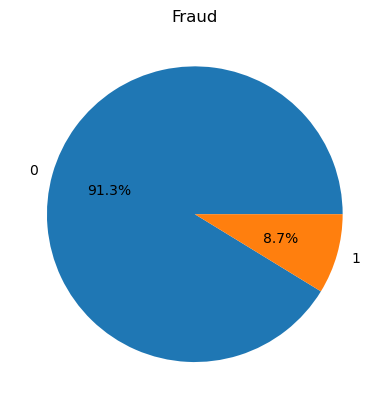

In [35]:
piechart=df['fraud'].value_counts()
plt.title("Fraud")
plt.pie(piechart,labels=["0","1"], autopct='%1.1f%%')

In [36]:
measure=df.describe()
measure

distance_from_home  distance_from_last_transaction  \
count      1000000.000000                  1000000.000000   
mean            26.628792                        5.036519   
std             65.390784                       25.843093   
min              0.004874                        0.000118   
25%              3.878008                        0.296671   
50%              9.967760                        0.998650   
75%             25.743985                        3.355748   
max          10632.723672                    11851.104565   

       ratio_to_median_purchase_price  repeat_retailer       used_chip  \
count                  1000000.000000   1000000.000000  1000000.000000   
mean                         1.824182         0.881536        0.350399   
std                          2.799589         0.323157        0.477095   
min                          0.004399         0.000000        0.000000   
25%                          0.475673         1.000000        0.000000   
50%                          0.997717         1.000000        0.000000   
75%                          2.096370         1.000000        1.000000   
max                        267.802942         1.000000        1.000000   

       used_pin_number    online_order           fraud  
count   1000000.000000  1000000.000000  1000000.000000  
mean          0.100608        0.650552        0.087403  
std           0.300809        0.476796        0.282425  
min           0.000000        0.000000        0.000000  
25%           0.000000        0.000000        0.000000  
50%           0.000000        1.000000        0.000000  
75%           0.000000        1.000000        0.000000  
max           1.000000        1.000000        1.000000

# Checking outliers 

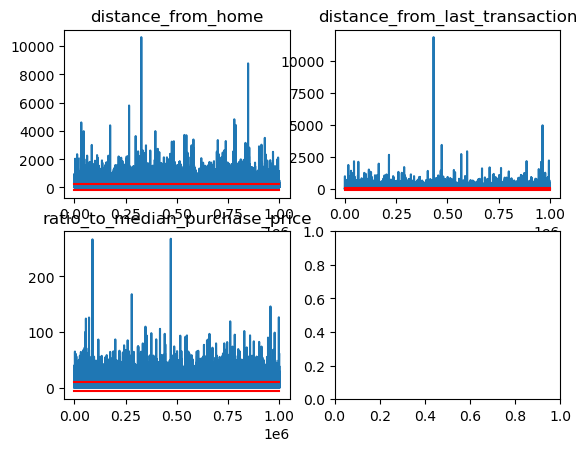

In [38]:
#outliers detection using standart deviation and mean
u=3
aElevation={}
bElevation={}

X=df.index.tolist()

for col in df.iloc[:,:3]:
    aElevation[col]=measure[col][1] - u*measure[col][2]
    bElevation[col]=measure[col][1] + u*measure[col][2]


figure, axis = plt.subplots(2, 2)
  
axis[0, 0].plot(X, df.iloc[:,0:1])
axis[0, 0].plot([0,1000000],[aElevation[df.columns[0]],aElevation[df.columns[0]]],color='red')
axis[0, 0].plot([0,1000000],[bElevation[df.columns[0]],bElevation[df.columns[0]]],color='red')
axis[0, 0].set_title(df.columns[0])
  

axis[0, 1].plot(X, df.iloc[:,1:2])
axis[0, 1].plot([0,1000000],[aElevation[df.columns[1]],aElevation[df.columns[1]]],color='red')
axis[0, 1].plot([0,1000000],[bElevation[df.columns[1]],bElevation[df.columns[1]]],color='red')
axis[0, 1].set_title(df.columns[1])
  

axis[1, 0].plot(X, df.iloc[:,2:3])
axis[1, 0].plot([0,1000000],[aElevation[df.columns[2]],aElevation[df.columns[2]]],color='red')
axis[1, 0].plot([0,1000000],[bElevation[df.columns[2]],bElevation[df.columns[2]]],color='red')
axis[1, 0].set_title(df.columns[2])
plt.show()

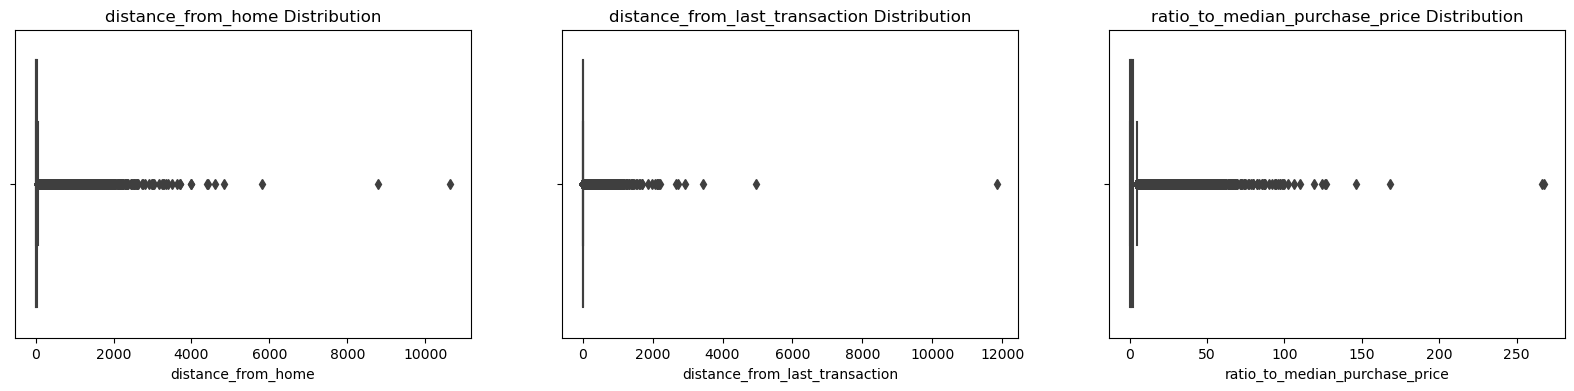

In [41]:
#check outliers with sns.boxplot
fig,ax = plt.subplots(1,3,figsize=(20,4))
for i,col in enumerate(list(df.iloc[:,:3])):
    sns.boxplot(data=df,x=col,ax=ax[i])
    ax[i].set_title(f'{col} Distribution')

There are many outliers in the graphs, but I won't remove them, coze outliers are more than 70% of the data, which would lead to the loss of important information

# Correlation

I will use sns.heatmap as the fastest method to visualize correlation matrix.

<Axes: >

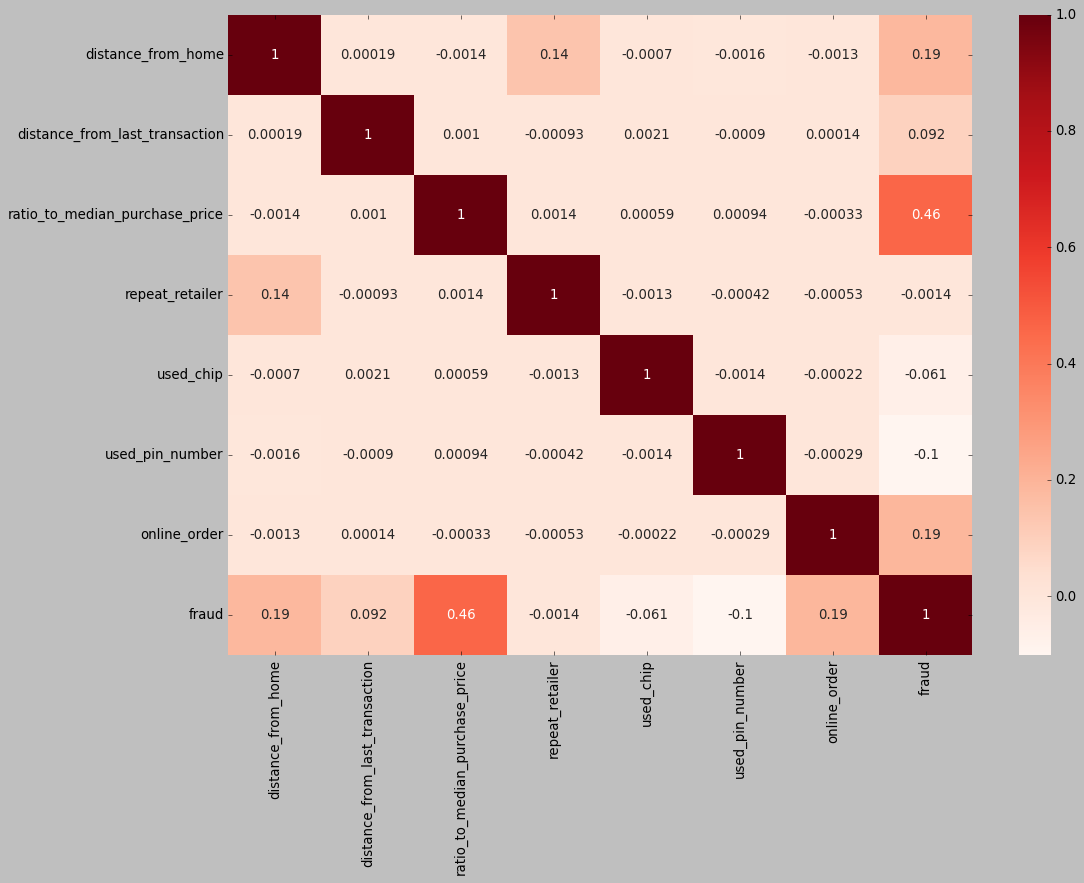

In [143]:
corr=df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr,cmap='Reds',annot=True)

# Preprocessing and split data

In [43]:
from sklearn.model_selection import train_test_split , GridSearchCV ,StratifiedKFold , cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix , precision_recall_curve , roc_auc_score , roc_curve , classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier ,plot_tree
from sklearn.ensemble import VotingClassifier ,RandomForestClassifier ,AdaBoostClassifier ,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [71]:
y=df['fraud']
x=df.iloc[:,:7]

In [70]:
x.tail(10)


distance_from_home  distance_from_last_transaction  \
999990           20.334489                       11.437333   
999991           26.807213                        0.102574   
999992            9.844674                        0.250108   
999993            4.846253                        2.844450   
999994            3.295884                        0.085712   
999995            2.207101                        0.112651   
999996           19.872726                        2.683904   
999997            2.914857                        1.472687   
999998            4.258729                        0.242023   
999999           58.108125                        0.318110   

        ratio_to_median_purchase_price  repeat_retailer  used_chip  \
999990                        0.699527              1.0        1.0   
999991                        2.746114              1.0        0.0   
999992                        0.814046              1.0        0.0   
999993                        0.867740              1.0        0.0   
999994                        0.831991              1.0        0.0   
999995                        1.626798              1.0        1.0   
999996                        2.778303              1.0        1.0   
999997                        0.218075              1.0        1.0   
999998                        0.475822              1.0        0.0   
999999                        0.386920              1.0        1.0   

        used_pin_number  online_order  
999990              0.0           1.0  
999991              0.0           1.0  
999992              0.0           1.0  
999993              0.0           1.0  
999994              0.0           1.0  
999995              0.0           0.0  
999996              0.0           0.0  
999997              0.0           1.0  
999998              0.0           1.0  
999999              0.0           1.0

In [74]:
X_train , X_test ,y_train , y_test = train_test_split(x,y,test_size = 0.1)


**To prevent "data leakage" scaling X_train and X_test separately**

In [82]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Using cross_validate() instead of  cross_val_score() in cross_val(model,x,y) for returning dict with more parameters

In [91]:
from sklearn.model_selection import cross_validate, cross_val_score,cross_val_predict
def cross_val(model,x,y):
  cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
  scoring=["accuracy",'precision_macro', 'recall_macro']
  cross_val=cross_validate(model,x, y,scoring=scoring,cv=cv,return_train_score=True)
  cv_predicts = cross_val_predict(model,x,y,cv=cv)
  model.fit(x,y)
  cv_predicts=pd.DataFrame(cv_predicts)
  print("Predicted class for each record:",cv_predicts.value_counts(),end='\n')
  
  return model,cross_val

def plot(cross_validate):
  plt.title("train and test accuracy")
  plt.plot(cross_validate['train_accuracy'])
  plt.plot(cross_validate['test_accuracy'])
  plt.legend(['train','test'])

def model_tunning(model,X_train,y_train,param_grid):
     
    grid_search=GridSearchCV(estimator=model,
                param_grid=param_grid,
                scoring='accuracy',
                verbose=3,
                return_train_score=True)
    grid_search.fit(X_train,y_train)
    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_
    best_score = grid_search.best_score_
    cv_results = pd.DataFrame(grid_search.cv_results_)
    print("Best parameters are: ",best_params)
    print('Mean cross-validated recall of the best_estimator is: ',best_score)
    print(best_estimator)
    return best_estimator
    

def conf_matrix(model,X_test,y_test,threshold):
  plt.figure(figsize=(5,4))
  y_proba_test = model.predict_proba(X_test)
  y_pred_test  = (y_proba_test[:,1]>=threshold)
  sns.heatmap(confusion_matrix(y_test,y_pred_test),cmap="Blues",annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  print(classification_report(y_test, model.predict(X_test), target_names=['Not Fraud', 'Fraud']))

def roc_curve_auc(model,X_test,y_test,threshold=0.5):
  y_proba_test = model.predict_proba(X_test)
  y_pred  = (y_proba_test[:,1])
  #y_pred = model.predict(X_test)
  fpr, tpr, _ = roc_curve(y_test, y_pred)
  #roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
  #roc_display.figure_.set_size_inches(5,5)
  #plt.plot([0, 1], [0, 1], color = 'g')
  fp_tp = pd.DataFrame({'Threshold':threshold,'False Pos Rate':fpr,'True Pos Rate':tpr})
  fig = px.line(
        fp_tp,
        x='False Pos Rate',
        y='True Pos Rate',
        title='ROC Curve',
        width=700,height=500,
        hover_data=['Threshold']
  )
  fig.show()
  score = roc_auc_score(y_test, y_pred)
  print(f"ROC AUC: {score:.4f}")

def indicators_cv(cv):
  indicators=pd.DataFrame(cv)
  indicators.loc['mean']= indicators.mean()
  return indicators

def precision_recall_trade_off(model,X_test,y_test):
    
    
    y_proba = model.predict_proba(X_test)
    precision ,recall ,threshold = precision_recall_curve(y_test,y_proba[:,1])
    p_r_t = pd.DataFrame({'Threshold':threshold,'Precision':precision[:-1],'Recall':recall[:-1]})
    fig = px.line(
        p_r_t,
        x='Recall',
        y='Precision',
        title='Precision-Recall Curve',
        width=700,height=500,
        hover_data=['Threshold']
    )
    fig.show()
    print(p_r_t[ (p_r_t['Recall']==1)])

from joblib import Parallel, delayed
import joblib
  
def save_model(model,model_name):
  joblib.dump(model, model_name+".pkl")




In [81]:
d=pd.DataFrame(X_train)
d.describe()

0             1             2             3             4  \
count  9.000000e+05  9.000000e+05  9.000000e+05  9.000000e+05  9.000000e+05   
mean  -1.141132e-16 -1.714776e-17 -1.378769e-16 -2.926252e-17 -5.731711e-17   
std    1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00   
min   -4.089255e-01 -1.931237e-01 -6.488810e-01 -2.728871e+00 -7.342331e-01   
25%   -3.493351e-01 -1.817931e-01 -4.807281e-01  3.664519e-01 -7.342331e-01   
50%   -2.557423e-01 -1.549216e-01 -2.942552e-01  3.664519e-01 -7.342331e-01   
75%   -1.327281e-02 -6.464435e-02  9.727044e-02  3.664519e-01  1.361965e+00   
max    1.630402e+02  4.531395e+02  9.481360e+01  3.664519e-01  1.361965e+00   

                  5             6  
count  9.000000e+05  9.000000e+05  
mean   2.896646e-17  7.035557e-17  
std    1.000001e+00  1.000001e+00  
min   -3.343920e-01 -1.364426e+00  
25%   -3.343920e-01 -1.364426e+00  
50%   -3.343920e-01  7.329090e-01  
75%   -3.343920e-01  7.329090e-01  
max    2.990502e+00  7.329090e-01

# RandomForestClassifier

In [83]:
rfc = RandomForestClassifier()
rfc,cv_rfc=cross_val(rfc,X_train, y_train)

Predicted class for each record: 0.0    821303
1.0     78697
dtype: int64


In [85]:
indicators_rfc=indicators_cv(cv_rfc)
indicators_rfc

fit_time  score_time  test_accuracy  train_accuracy  \
0     142.691866    1.595042       0.999989             1.0   
1     132.406720    1.561559       1.000000             1.0   
2     139.891852    1.597073       1.000000             1.0   
3     138.228318    1.621837       0.999994             1.0   
4     136.292502    1.667054       0.999983             1.0   
mean  137.902252    1.608513       0.999993             1.0   

      test_precision_macro  train_precision_macro  test_recall_macro  \
0                 0.999994                    1.0           0.999936   
1                 1.000000                    1.0           1.000000   
2                 1.000000                    1.0           1.000000   
3                 0.999997                    1.0           0.999968   
4                 0.999991                    1.0           0.999905   
mean              0.999996                    1.0           0.999962   

      train_recall_macro  
0                    1.0  
1                    1.0  
2                    1.0  
3                    1.0  
4                    1.0  
mean                 1.0

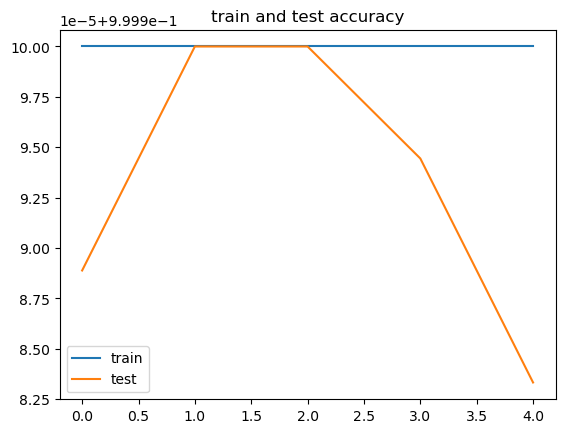

In [126]:
plot(cv_rfc)

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     91300
       Fraud       1.00      1.00      1.00      8700

    accuracy                           1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000



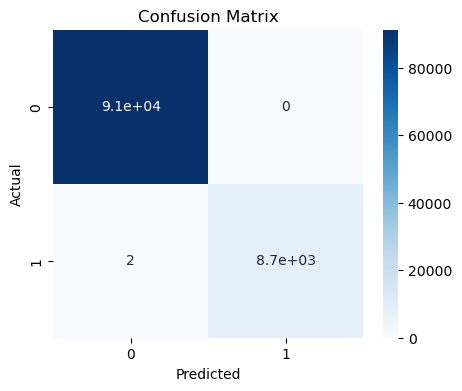

In [96]:
#picking threshold as 0.75, not default o.5, for preventing misclassifying a few nefative observations as positive
conf_matrix(rfc,X_test,y_test,0.75)

In [88]:
precision_recall_trade_off(rfc,X_test,y_test)

    Threshold  Precision  Recall
0        0.00   0.087000     1.0
1        0.01   0.935886     1.0
2        0.02   0.981830     1.0
3        0.03   0.989311     1.0
4        0.04   0.994059     1.0
5        0.05   0.995765     1.0
6        0.06   0.997935     1.0
7        0.07   0.998279     1.0
8        0.08   0.998852     1.0
9        0.10   0.999081     1.0
10       0.11   0.999196     1.0
11       0.14   0.999426     1.0
12       0.16   0.999655     1.0
13       0.17   0.999770     1.0


In [89]:
roc_curve_auc(rfc,X_test,y_test)

ROC AUC: 1.0000


Model accuracy is high, so I am saving model using joblib in save_model()

In [92]:
save_model(rfc,"RandomForest")

# GradientBoostingClassifier

In [93]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc,cv_gbc=cross_val(gbc,X_train, y_train)


Predicted class for each record: 0.0    821426
1.0     78574
dtype: int64


In [94]:
indicators_gbc=indicators_cv(cv_gbc)
indicators_gbc

fit_time  score_time  test_accuracy  train_accuracy  \
0     204.605823    0.456874       0.999633        0.999671   
1     201.000220    0.468598       0.999861        0.999883   
2     199.461996    0.463103       0.999806        0.999794   
3     199.551200    0.465287       0.999878        0.999911   
4     201.347322    0.485819       0.999872        0.999890   
mean  201.193312    0.467936       0.999810        0.999830   

      test_precision_macro  train_precision_macro  test_recall_macro  \
0                 0.999482               0.999553           0.998219   
1                 0.999809               0.999785           0.999321   
2                 0.999778               0.999851           0.999003   
3                 0.999933               0.999930           0.999301   
4                 0.999872               0.999918           0.999327   
mean              0.999775               0.999808           0.999034   

      train_recall_macro  
0               0.998384  
1               0.999484  
2               0.998861  
3               0.999513  
4               0.999394  
mean            0.999127

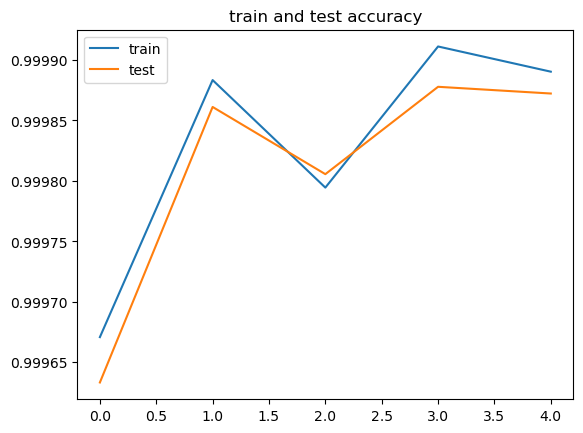

In [125]:
plot(cv_gbc)

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     91300
       Fraud       1.00      1.00      1.00      8700

    accuracy                           1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000



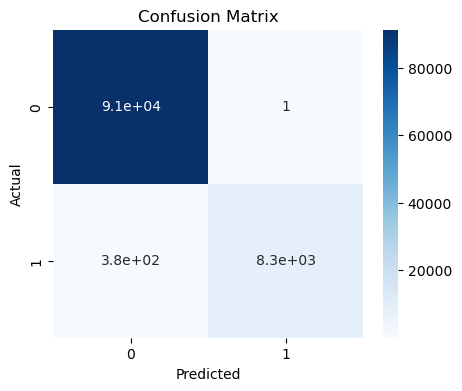

In [99]:
conf_matrix(gbc,X_test,y_test,0.75)

In [100]:
precision_recall_trade_off(gbc,X_test,y_test)

    Threshold  Precision  Recall
0    0.000003   0.087000     1.0
1    0.000003   0.087052     1.0
2    0.000004   0.087053     1.0
3    0.000007   0.087054     1.0
4    0.000010   0.087831     1.0
..        ...        ...     ...
78   0.137084   0.946784     1.0
79   0.147924   0.951756     1.0
80   0.150913   0.975118     1.0
81   0.159254   0.975227     1.0
82   0.161021   0.979068     1.0

[83 rows x 3 columns]


In [101]:
roc_curve_auc(gbc,X_test,y_test)

ROC AUC: 1.0000


In [117]:
save_model(gbc,"GradientBoostingClassifier")

# LogisticRegression

In [103]:
lg = LogisticRegression()
lg,cv_lg=cross_val(lg,X_train, y_train)

Predicted class for each record: 0.0    846868
1.0     53132
dtype: int64


In [105]:
indicators_lg=indicators_cv(cv_lg)
indicators_lg

fit_time  score_time  test_accuracy  train_accuracy  \
0     1.900782    0.283952       0.959189        0.958617   
1     1.835020    0.292263       0.958506        0.958983   
2     1.837334    0.286475       0.958750        0.958940   
3     1.714563    0.297762       0.958661        0.959110   
4     1.793290    0.312569       0.959344        0.958676   
mean  1.816198    0.294604       0.958890        0.958865   

      test_precision_macro  train_precision_macro  test_recall_macro  \
0                 0.928308               0.927344           0.799360   
1                 0.926958               0.927952           0.795769   
2                 0.926633               0.927984           0.797754   
3                 0.927220               0.927832           0.796642   
4                 0.929663               0.927497           0.799314   
mean              0.927756               0.927722           0.797768   

      train_recall_macro  
0               0.796227  
1               0.798252  
2               0.797923  
3               0.799222  
4               0.796508  
mean            0.797626

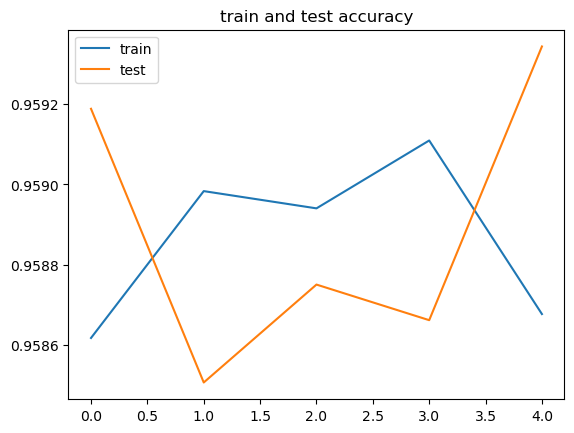

In [124]:
plot(cv_lg)

Difference between test_accuracy and test_recall_macro is big, so let's find cross_val_score() with scoring="recall", not "accuracy" like in cross_val(lg,X_train, y_train)

In [110]:
splits = StratifiedKFold(n_splits=5)
validate = cross_val_score(lg,X_train,y_train,scoring="recall",cv=splits)
validate
print(validate.mean())

0.6021624902215155


In [111]:
validate

array([0.59853875, 0.60025413, 0.6049171 , 0.6073947 , 0.59970777])

In [119]:
#tunning LogReg model
searchLg={
    "penalty":["l1","l2","elasticnet"],
    "solver":["newton-cg","lbfgs","liblinear","sag","saga"],

    "C":[0.01, 0.1,3,5,10,100]

}

lg_tuning=model_tunning(LogisticRegression(),X_train,y_train,searchLg)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5] END C=0.01, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.1s
[CV 2/5] END C=0.01, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.1s
[CV 3/5] END C=0.01, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.1s
[CV 4/5] END C=0.01, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.1s
[CV 5/5] END C=0.01, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=0.01, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=0.01, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=0.01, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=0.01, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=0.01, penalty=l1, solver=lbfgs;, score=(train=na

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 1/5] END C=0.01, penalty=l1, solver=saga;, score=(train=0.955, test=0.955) total time=  51.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 2/5] END C=0.01, penalty=l1, solver=saga;, score=(train=0.955, test=0.955) total time=  51.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 3/5] END C=0.01, penalty=l1, solver=saga;, score=(train=0.958, test=0.958) total time=  52.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 4/5] END C=0.01, penalty=l1, solver=saga;, score=(train=0.955, test=0.955) total time=  48.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 5/5] END C=0.01, penalty=l1, solver=saga;, score=(train=0.955, test=0.955) total time=  50.8s
[CV 1/5] END C=0.01, penalty=l2, solver=newton-cg;, score=(train=0.957, test=0.957) total time=   4.7s
[CV 2/5] END C=0.01, penalty=l2, solver=newton-cg;, score=(train=0.958, test=0.958) total time=   5.5s
[CV 3/5] END C=0.01, penalty=l2, solver=newton-cg;, score=(train=0.958, test=0.957) total time=   4.5s
[CV 4/5] END C=0.01, penalty=l2, solver=newton-cg;, score=(train=0.957, test=0.958) total time=   4.4s
[CV 5/5] END C=0.01, penalty=l2, solver=newton-cg;, score=(train=0.958, test=0.957) total time=   4.3s
[CV 1/5] END C=0.01, penalty=l2, solver=lbfgs;, score=(train=0.957, test=0.957) total time=   2.0s
[CV 2/5] END C=0.01, penalty=l2, solver=lbfgs;, score=(train=0.958, test=0.958) total time=   1.6s
[CV 3/5] END C=0.01, penalty=l2, solver=lbfgs;, score=(train=0.958, test=0.957) total time=   1.6s
[CV 4/5] END C=0.01, penalty=l2, solver=lbfgs;, score=(train=0.957, test=0.958) total time

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 1/5] END C=0.01, penalty=l2, solver=sag;, score=(train=0.956, test=0.956) total time=  45.0s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 2/5] END C=0.01, penalty=l2, solver=sag;, score=(train=0.957, test=0.956) total time=  46.3s
[CV 3/5] END C=0.01, penalty=l2, solver=sag;, score=(train=0.958, test=0.957) total time=  35.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 4/5] END C=0.01, penalty=l2, solver=sag;, score=(train=0.956, test=0.957) total time=  48.9s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 5/5] END C=0.01, penalty=l2, solver=sag;, score=(train=0.957, test=0.956) total time=  49.0s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 1/5] END C=0.01, penalty=l2, solver=saga;, score=(train=0.954, test=0.955) total time=  49.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 2/5] END C=0.01, penalty=l2, solver=saga;, score=(train=0.955, test=0.955) total time=  50.0s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 3/5] END C=0.01, penalty=l2, solver=saga;, score=(train=0.958, test=0.957) total time=  51.0s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 4/5] END C=0.01, penalty=l2, solver=saga;, score=(train=0.954, test=0.955) total time=  47.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 5/5] END C=0.01, penalty=l2, solver=saga;, score=(train=0.955, test=0.954) total time=  48.8s
[CV 1/5] END C=0.01, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.1s
[CV 2/5] END C=0.01, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=0.01, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.1s
[CV 4/5] END C=0.01, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.1s
[CV 5/5] END C=0.01, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.1s
[CV 1/5] END C=0.01, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.1s
[CV 2/5] END C=0.01, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.1s
[CV 3/5] END C=0.01, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.1s
[CV 4/5] END C=0.01, penalty=elasticnet, solver=lbfgs;, sc

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 1/5] END C=0.1, penalty=l1, solver=saga;, score=(train=0.955, test=0.955) total time=  52.4s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 2/5] END C=0.1, penalty=l1, solver=saga;, score=(train=0.955, test=0.955) total time=  49.4s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 3/5] END C=0.1, penalty=l1, solver=saga;, score=(train=0.959, test=0.959) total time=  48.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 4/5] END C=0.1, penalty=l1, solver=saga;, score=(train=0.955, test=0.956) total time=  49.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 5/5] END C=0.1, penalty=l1, solver=saga;, score=(train=0.955, test=0.955) total time=  48.1s
[CV 1/5] END C=0.1, penalty=l2, solver=newton-cg;, score=(train=0.959, test=0.959) total time=   5.5s
[CV 2/5] END C=0.1, penalty=l2, solver=newton-cg;, score=(train=0.959, test=0.959) total time=   4.5s
[CV 3/5] END C=0.1, penalty=l2, solver=newton-cg;, score=(train=0.959, test=0.959) total time=   4.8s
[CV 4/5] END C=0.1, penalty=l2, solver=newton-cg;, score=(train=0.959, test=0.959) total time=   4.6s
[CV 5/5] END C=0.1, penalty=l2, solver=newton-cg;, score=(train=0.959, test=0.958) total time=   4.8s
[CV 1/5] END C=0.1, penalty=l2, solver=lbfgs;, score=(train=0.959, test=0.959) total time=   1.9s
[CV 2/5] END C=0.1, penalty=l2, solver=lbfgs;, score=(train=0.959, test=0.959) total time=   1.9s
[CV 3/5] END C=0.1, penalty=l2, solver=lbfgs;, score=(train=0.959, test=0.959) total time=   1.9s
[CV 4/5] END C=0.1, penalty=l2, solver=lbfgs;, score=(train=0.959, test=0.959) total time=   2.0s
[

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 1/5] END C=0.1, penalty=l2, solver=sag;, score=(train=0.957, test=0.957) total time=  44.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 2/5] END C=0.1, penalty=l2, solver=sag;, score=(train=0.957, test=0.957) total time=  42.4s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 3/5] END C=0.1, penalty=l2, solver=sag;, score=(train=0.959, test=0.959) total time=  45.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 4/5] END C=0.1, penalty=l2, solver=sag;, score=(train=0.957, test=0.958) total time=  46.8s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 5/5] END C=0.1, penalty=l2, solver=sag;, score=(train=0.957, test=0.957) total time=  44.5s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 1/5] END C=0.1, penalty=l2, solver=saga;, score=(train=0.955, test=0.955) total time=  43.9s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 2/5] END C=0.1, penalty=l2, solver=saga;, score=(train=0.955, test=0.955) total time=  43.8s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 3/5] END C=0.1, penalty=l2, solver=saga;, score=(train=0.959, test=0.958) total time=  46.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 4/5] END C=0.1, penalty=l2, solver=saga;, score=(train=0.955, test=0.956) total time=  49.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 5/5] END C=0.1, penalty=l2, solver=saga;, score=(train=0.955, test=0.955) total time=  56.3s
[CV 1/5] END C=0.1, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.1s
[CV 2/5] END C=0.1, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.1s
[CV 3/5] END C=0.1, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.1s
[CV 4/5] END C=0.1, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.1s
[CV 5/5] END C=0.1, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.1s
[CV 1/5] END C=0.1, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=0.1, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=0.1, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.1s
[CV 4/5] END C=0.1, penalty=elasticnet, solver=lbfgs;, score=(train

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 1/5] END C=3, penalty=l1, solver=saga;, score=(train=0.955, test=0.955) total time=  55.9s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 2/5] END C=3, penalty=l1, solver=saga;, score=(train=0.955, test=0.955) total time=  51.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 3/5] END C=3, penalty=l1, solver=saga;, score=(train=0.959, test=0.959) total time=  52.8s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 4/5] END C=3, penalty=l1, solver=saga;, score=(train=0.955, test=0.956) total time=  51.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 5/5] END C=3, penalty=l1, solver=saga;, score=(train=0.955, test=0.955) total time=  50.2s
[CV 1/5] END C=3, penalty=l2, solver=newton-cg;, score=(train=0.959, test=0.959) total time=   5.9s
[CV 2/5] END C=3, penalty=l2, solver=newton-cg;, score=(train=0.959, test=0.959) total time=   5.7s
[CV 3/5] END C=3, penalty=l2, solver=newton-cg;, score=(train=0.959, test=0.959) total time=   5.0s
[CV 4/5] END C=3, penalty=l2, solver=newton-cg;, score=(train=0.959, test=0.959) total time=   5.0s
[CV 5/5] END C=3, penalty=l2, solver=newton-cg;, score=(train=0.959, test=0.959) total time=   5.3s
[CV 1/5] END C=3, penalty=l2, solver=lbfgs;, score=(train=0.959, test=0.959) total time=   1.8s
[CV 2/5] END C=3, penalty=l2, solver=lbfgs;, score=(train=0.959, test=0.959) total time=   1.8s
[CV 3/5] END C=3, penalty=l2, solver=lbfgs;, score=(train=0.959, test=0.959) total time=   1.9s
[CV 4/5] END C=3, penalty=l2, solver=lbfgs;, score=(train=0.959, test=0.959) total time=   1.8s
[CV 5/5] END C=3, pen

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 1/5] END C=3, penalty=l2, solver=sag;, score=(train=0.957, test=0.957) total time=  42.0s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 2/5] END C=3, penalty=l2, solver=sag;, score=(train=0.957, test=0.957) total time=  42.4s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 3/5] END C=3, penalty=l2, solver=sag;, score=(train=0.959, test=0.959) total time=  44.0s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 4/5] END C=3, penalty=l2, solver=sag;, score=(train=0.957, test=0.958) total time=  43.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 5/5] END C=3, penalty=l2, solver=sag;, score=(train=0.957, test=0.957) total time=  45.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 1/5] END C=3, penalty=l2, solver=saga;, score=(train=0.955, test=0.955) total time=  45.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 2/5] END C=3, penalty=l2, solver=saga;, score=(train=0.955, test=0.955) total time=  46.8s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 3/5] END C=3, penalty=l2, solver=saga;, score=(train=0.959, test=0.959) total time=  45.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 4/5] END C=3, penalty=l2, solver=saga;, score=(train=0.955, test=0.956) total time=  45.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 5/5] END C=3, penalty=l2, solver=saga;, score=(train=0.955, test=0.955) total time=  48.4s
[CV 1/5] END C=3, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=3, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=3, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=3, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.1s
[CV 5/5] END C=3, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=3, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=3, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=3, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=3, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) tota

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 1/5] END C=5, penalty=l1, solver=saga;, score=(train=0.955, test=0.955) total time=  49.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 2/5] END C=5, penalty=l1, solver=saga;, score=(train=0.955, test=0.955) total time=  52.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 3/5] END C=5, penalty=l1, solver=saga;, score=(train=0.959, test=0.959) total time=  51.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 4/5] END C=5, penalty=l1, solver=saga;, score=(train=0.955, test=0.956) total time=  51.0s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 5/5] END C=5, penalty=l1, solver=saga;, score=(train=0.955, test=0.955) total time=  51.7s


/opt/conda/lib/python3.10/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning:

The line search algorithm did not converge

/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning:

Line Search failed



[CV 1/5] END C=5, penalty=l2, solver=newton-cg;, score=(train=0.959, test=0.959) total time=   9.7s
[CV 2/5] END C=5, penalty=l2, solver=newton-cg;, score=(train=0.959, test=0.959) total time=   5.8s
[CV 3/5] END C=5, penalty=l2, solver=newton-cg;, score=(train=0.959, test=0.959) total time=   5.2s
[CV 4/5] END C=5, penalty=l2, solver=newton-cg;, score=(train=0.959, test=0.959) total time=   5.3s
[CV 5/5] END C=5, penalty=l2, solver=newton-cg;, score=(train=0.959, test=0.959) total time=   5.3s
[CV 1/5] END C=5, penalty=l2, solver=lbfgs;, score=(train=0.959, test=0.959) total time=   1.9s
[CV 2/5] END C=5, penalty=l2, solver=lbfgs;, score=(train=0.959, test=0.959) total time=   1.8s
[CV 3/5] END C=5, penalty=l2, solver=lbfgs;, score=(train=0.959, test=0.959) total time=   1.9s
[CV 4/5] END C=5, penalty=l2, solver=lbfgs;, score=(train=0.959, test=0.959) total time=   1.9s
[CV 5/5] END C=5, penalty=l2, solver=lbfgs;, score=(train=0.959, test=0.959) total time=   1.9s
[CV 1/5] END C=5, pe

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 1/5] END C=5, penalty=l2, solver=sag;, score=(train=0.957, test=0.957) total time=  45.4s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 2/5] END C=5, penalty=l2, solver=sag;, score=(train=0.957, test=0.957) total time=  46.8s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 3/5] END C=5, penalty=l2, solver=sag;, score=(train=0.959, test=0.959) total time=  44.4s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 4/5] END C=5, penalty=l2, solver=sag;, score=(train=0.957, test=0.958) total time=  44.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 5/5] END C=5, penalty=l2, solver=sag;, score=(train=0.957, test=0.957) total time=  51.5s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 1/5] END C=5, penalty=l2, solver=saga;, score=(train=0.955, test=0.955) total time=  47.5s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 2/5] END C=5, penalty=l2, solver=saga;, score=(train=0.955, test=0.955) total time=  48.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 3/5] END C=5, penalty=l2, solver=saga;, score=(train=0.959, test=0.959) total time=  50.8s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 4/5] END C=5, penalty=l2, solver=saga;, score=(train=0.955, test=0.956) total time=  47.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 5/5] END C=5, penalty=l2, solver=saga;, score=(train=0.955, test=0.955) total time=  49.1s
[CV 1/5] END C=5, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.1s
[CV 2/5] END C=5, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.1s
[CV 3/5] END C=5, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.1s
[CV 4/5] END C=5, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.1s
[CV 5/5] END C=5, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.1s
[CV 1/5] END C=5, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.1s
[CV 2/5] END C=5, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=5, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.1s
[CV 4/5] END C=5, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) tota

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 1/5] END C=10, penalty=l1, solver=saga;, score=(train=0.955, test=0.955) total time=  55.4s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 2/5] END C=10, penalty=l1, solver=saga;, score=(train=0.955, test=0.955) total time=  53.8s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 3/5] END C=10, penalty=l1, solver=saga;, score=(train=0.959, test=0.959) total time=  53.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 4/5] END C=10, penalty=l1, solver=saga;, score=(train=0.955, test=0.956) total time=  52.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 5/5] END C=10, penalty=l1, solver=saga;, score=(train=0.955, test=0.955) total time=  53.1s
[CV 1/5] END C=10, penalty=l2, solver=newton-cg;, score=(train=0.959, test=0.959) total time=   5.4s
[CV 2/5] END C=10, penalty=l2, solver=newton-cg;, score=(train=0.959, test=0.959) total time=   5.7s
[CV 3/5] END C=10, penalty=l2, solver=newton-cg;, score=(train=0.959, test=0.959) total time=   5.1s
[CV 4/5] END C=10, penalty=l2, solver=newton-cg;, score=(train=0.959, test=0.959) total time=   5.3s
[CV 5/5] END C=10, penalty=l2, solver=newton-cg;, score=(train=0.959, test=0.959) total time=   5.3s
[CV 1/5] END C=10, penalty=l2, solver=lbfgs;, score=(train=0.959, test=0.959) total time=   1.9s
[CV 2/5] END C=10, penalty=l2, solver=lbfgs;, score=(train=0.959, test=0.959) total time=   1.9s
[CV 3/5] END C=10, penalty=l2, solver=lbfgs;, score=(train=0.959, test=0.959) total time=   2.0s
[CV 4/5] END C=10, penalty=l2, solver=lbfgs;, score=(train=0.959, test=0.959) total time=   1.9s
[CV 5/5] EN

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 1/5] END C=10, penalty=l2, solver=sag;, score=(train=0.957, test=0.957) total time=  45.4s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 2/5] END C=10, penalty=l2, solver=sag;, score=(train=0.957, test=0.957) total time=  49.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 3/5] END C=10, penalty=l2, solver=sag;, score=(train=0.959, test=0.959) total time=  44.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 4/5] END C=10, penalty=l2, solver=sag;, score=(train=0.957, test=0.958) total time=  45.4s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 5/5] END C=10, penalty=l2, solver=sag;, score=(train=0.957, test=0.957) total time=  46.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 1/5] END C=10, penalty=l2, solver=saga;, score=(train=0.955, test=0.955) total time=  47.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 2/5] END C=10, penalty=l2, solver=saga;, score=(train=0.955, test=0.955) total time=  46.9s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 3/5] END C=10, penalty=l2, solver=saga;, score=(train=0.959, test=0.959) total time=  44.8s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 4/5] END C=10, penalty=l2, solver=saga;, score=(train=0.955, test=0.956) total time=  47.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 5/5] END C=10, penalty=l2, solver=saga;, score=(train=0.955, test=0.955) total time=  46.8s
[CV 1/5] END C=10, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=10, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=10, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.1s
[CV 4/5] END C=10, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=10, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.1s
[CV 1/5] END C=10, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=10, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=10, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=10, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 1/5] END C=100, penalty=l1, solver=saga;, score=(train=0.955, test=0.955) total time=  53.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 2/5] END C=100, penalty=l1, solver=saga;, score=(train=0.955, test=0.955) total time=  49.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 3/5] END C=100, penalty=l1, solver=saga;, score=(train=0.959, test=0.959) total time=  49.4s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 4/5] END C=100, penalty=l1, solver=saga;, score=(train=0.955, test=0.956) total time=  50.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 5/5] END C=100, penalty=l1, solver=saga;, score=(train=0.955, test=0.955) total time=  49.4s
[CV 1/5] END C=100, penalty=l2, solver=newton-cg;, score=(train=0.959, test=0.959) total time=   6.0s
[CV 2/5] END C=100, penalty=l2, solver=newton-cg;, score=(train=0.959, test=0.959) total time=   5.0s
[CV 3/5] END C=100, penalty=l2, solver=newton-cg;, score=(train=0.959, test=0.959) total time=   5.2s
[CV 4/5] END C=100, penalty=l2, solver=newton-cg;, score=(train=0.959, test=0.959) total time=   5.3s
[CV 5/5] END C=100, penalty=l2, solver=newton-cg;, score=(train=0.959, test=0.959) total time=   5.4s
[CV 1/5] END C=100, penalty=l2, solver=lbfgs;, score=(train=0.959, test=0.959) total time=   1.9s
[CV 2/5] END C=100, penalty=l2, solver=lbfgs;, score=(train=0.959, test=0.959) total time=   1.9s
[CV 3/5] END C=100, penalty=l2, solver=lbfgs;, score=(train=0.959, test=0.959) total time=   2.5s
[CV 4/5] END C=100, penalty=l2, solver=lbfgs;, score=(train=0.959, test=0.959) total time=   1.9s
[

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 1/5] END C=100, penalty=l2, solver=sag;, score=(train=0.957, test=0.957) total time=  46.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 2/5] END C=100, penalty=l2, solver=sag;, score=(train=0.957, test=0.957) total time=  45.0s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 3/5] END C=100, penalty=l2, solver=sag;, score=(train=0.959, test=0.959) total time=  47.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 4/5] END C=100, penalty=l2, solver=sag;, score=(train=0.957, test=0.958) total time=  47.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 5/5] END C=100, penalty=l2, solver=sag;, score=(train=0.957, test=0.957) total time=  42.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 1/5] END C=100, penalty=l2, solver=saga;, score=(train=0.955, test=0.955) total time=  44.8s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 2/5] END C=100, penalty=l2, solver=saga;, score=(train=0.955, test=0.955) total time=  46.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 3/5] END C=100, penalty=l2, solver=saga;, score=(train=0.959, test=0.959) total time=  45.9s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 4/5] END C=100, penalty=l2, solver=saga;, score=(train=0.955, test=0.956) total time=  47.5s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV 5/5] END C=100, penalty=l2, solver=saga;, score=(train=0.955, test=0.955) total time=  45.3s
[CV 1/5] END C=100, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=100, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=100, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.1s
[CV 4/5] END C=100, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.1s
[CV 5/5] END C=100, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.1s
[CV 1/5] END C=100, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.1s
[CV 2/5] END C=100, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.1s
[CV 3/5] END C=100, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.1s
[CV 4/5] END C=100, penalty=elasticnet, solver=lbfgs;, score=(train

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


240 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: So

Best parameters are:  {'C': 5, 'penalty': 'l2', 'solver': 'lbfgs'}
Mean cross-validated recall of the best_estimator is:  0.9588733333333334
LogisticRegression(C=5)


              precision    recall  f1-score   support

   Not Fraud       0.96      0.99      0.98     91300
       Fraud       0.89      0.60      0.72      8700

    accuracy                           0.96    100000
   macro avg       0.93      0.80      0.85    100000
weighted avg       0.96      0.96      0.96    100000



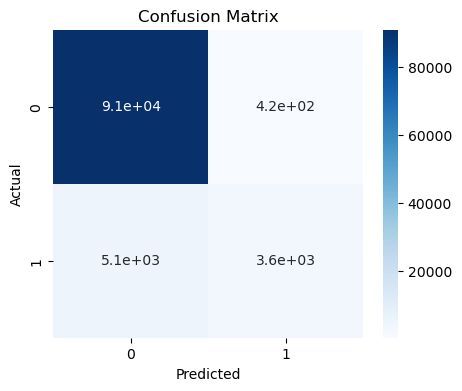

In [120]:
conf_matrix(lg_tuning,X_test,y_test,0.75)

In [121]:
precision_recall_trade_off(lg_tuning,X_test,y_test)

         Threshold  Precision  Recall
0     7.314269e-12   0.087000     1.0
1     7.672913e-12   0.087001     1.0
2     7.706188e-12   0.087002     1.0
3     7.726173e-12   0.087003     1.0
4     7.749243e-12   0.087003     1.0
...            ...        ...     ...
9377  8.010234e-07   0.096002     1.0
9378  8.043105e-07   0.096003     1.0
9379  8.079904e-07   0.096004     1.0
9380  8.131229e-07   0.096005     1.0
9381  8.138869e-07   0.096006     1.0

[9382 rows x 3 columns]


In [122]:
roc_curve_auc(lg_tuning,X_test,y_test)

ROC AUC: 0.9666


In [123]:
save_model(lg_tuning,"TuningLogReg")

# NN

In [128]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback



In [129]:
model = Sequential()
model.add(InputLayer((X_train.shape[1],)))
model.add(Dense(128, 'relu'))
model.add(Dense(128, 'relu'))
model.add(BatchNormalization())
model.add(Dense(128, 'relu'))
model.add(Dense(128, 'relu'))
model.add(Dense(1, 'sigmoid'))

callback = EarlyStopping(
    monitor="val_loss",
    patience=1,
    restore_best_weights=True
)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [130]:
history =model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, callbacks=[callback])

Epoch 1/40
28125/28125 [==============================] - 95s 3ms/step - loss: 0.0159 - accuracy: 0.9939 - val_loss: 0.0118 - val_accuracy: 0.9967
Epoch 2/40
28125/28125 [==============================] - 92s 3ms/step - loss: 0.0092 - accuracy: 0.9965 - val_loss: 0.0096 - val_accuracy: 0.9964
Epoch 3/40
28125/28125 [==============================] - 92s 3ms/step - loss: 0.0075 - accuracy: 0.9972 - val_loss: 0.0089 - val_accuracy: 0.9964
Epoch 4/40
28125/28125 [==============================] - 96s 3ms/step - loss: 0.0068 - accuracy: 0.9975 - val_loss: 0.0054 - val_accuracy: 0.9988
Epoch 5/40
28125/28125 [==============================] - 93s 3ms/step - loss: 0.0060 - accuracy: 0.9978 - val_loss: 0.0135 - val_accuracy: 0.9968


In [131]:
filename = 'fraud_detection_model.h5'
model.save(filename)

In [132]:

def histogram(history):
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  xc = range(len(train_acc))

  a=plt.figure(1,figsize=(7,5))

  plt.plot(xc,train_loss)
  plt.plot(xc,val_loss)
  plt.xlabel('num of Epochs')
  plt.ylabel('loss')
  plt.title('train_loss vs val_loss')
  plt.grid(True)
  plt.legend(['train','val'])

  plt.style.use(['classic'])

  b=plt.figure(2,figsize=(7,5))
  plt.plot(xc,train_acc)
  plt.plot(xc,val_acc)
  plt.xlabel('num of Epochs')
  plt.ylabel('accuracy')
  plt.title('train_acc vs val_acc')
  plt.grid(True)
  plt.legend(['train','val'],loc=4)
  plt.style.use(['classic'])
  return a,b

(<Figure size 700x500 with 1 Axes>, <Figure size 560x400 with 1 Axes>)


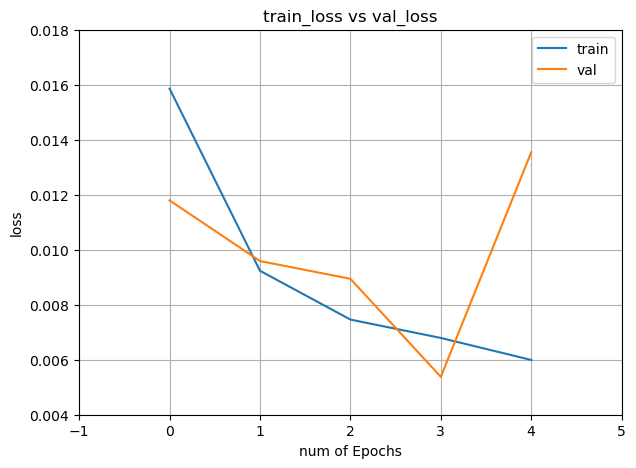

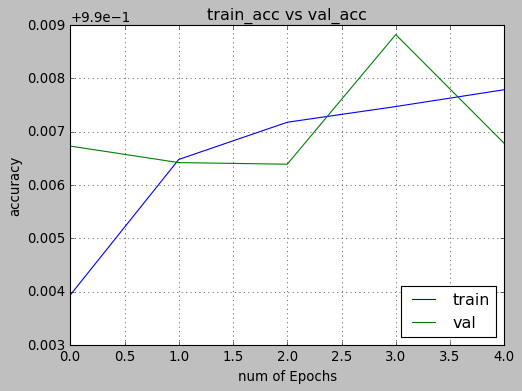

In [133]:
print(histogram(history))

# Conclusion
* Data: outliers are more than 70% of the data, so removing them will badly affect models
* Models: The most accurate models are GradientBoostingClassifier and RandomForestClassifier, but due to problems with overfitting, the most fitting model is NN
